In [1]:
from calibrate.cluster_model import ClusterFactory, ClusteringOptimizer
from calibrate.cointegration import CointegrrationTest, BasketCointegrationTest
from calibrate.OU_calibration import OUCalibration
from calibrate.baskets import Basket
from metric_calculation.backtest import BackTest
from utils.price_data_utils import get_time_series
from strategy.simple_implementation import OUTrader
import matplotlib.pyplot as plt
%matplotlib inline

# Fill these cells after running the data parsing script
sector = "Energy"
data_start_date = 20050101
data_end_date = 20170101

backtest_start_date = 20180101
backtest_end_date = 20250701
initial_capital = 100000

In [2]:
start_date = data_start_date
end_date = data_end_date
results = {}
for method in ["kmeans", "gmm", "hierarchical", "spectral"]:
    print(f"\n--- Testing {method.upper()} ---")
    model = ClusterFactory.create(method, sector, start_date, end_date)
    optimizer = ClusteringOptimizer(model)
    best_params, best_score, all_results = optimizer.search()
    print(f"Best_parameters: {best_params}")
    print(f"custom score: {best_score}")
    results[method] = (best_params, best_score)


--- Testing KMEANS ---
Best_parameters: {'n_clusters': 9}
custom score: 0.48410328125383084

--- Testing GMM ---
Best_parameters: {'n_components': 7, 'covariance_type': 'tied'}
custom score: 0.22587259178057217

--- Testing HIERARCHICAL ---
Best_parameters: {'n_clusters': 10, 'linkage': 'complete'}
custom score: 0.6198787833808388

--- Testing SPECTRAL ---
Best_parameters: {'n_clusters': 9, 'affinity': 'rbf'}
custom score: 0.23839573127806912


In [3]:
# Best parameters and clustering method
best_method, (best_params, best_score) = max(results.items(), key=lambda x: x[1][1])
print(f"\nBest method: {best_method.upper()} with score {best_score}")

# Getting Clustered Data
model = ClusterFactory.create(best_method, sector, start_date, end_date, **best_params)
model.fit()
model.show_baskets()
model.evaluate()
clustered_data = model.get_clustered_data()


Best method: HIERARCHICAL with score 0.6198787833808388

Cluster 0 (4 items):
['HAL', 'MPC', 'VLO', 'WMB']

Cluster 1 (2 items):
['OKE', 'PSX']

Cluster 2 (2 items):
['ANDV', 'HES']

Cluster 3 (2 items):
['CVX', 'COP']

Cluster 4 (2 items):
['NFX', 'RRC']

Cluster 5 (1 items):
['XOM']

Cluster 6 (6 items):
['APA', 'DVN', 'EOG', 'OXY', 'SLB', 'FTI']

Cluster 7 (1 items):
['EQT']

Cluster 8 (1 items):
['KMI']

Cluster 9 (2 items):
['HP', 'NOV']


In [4]:
# Getting Price data for the dates
price_data = get_time_series(clustered_data, start_date, end_date)

c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  20 of 20 completed
c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


In [5]:
# Running Cointegration Tests for all the baskets and get the optimum weights if clustered
cointegration_test = CointegrrationTest(price_data, clustered_data)
cointegrated_clustrs = cointegration_test.get_cointegrated_clusters()
print("\n--- Cointegrated Clusters ---")
for cluster in cointegrated_clustrs:
    print(f"Cluster: {cluster}")
    print(f"  Cointegration Type: {cointegrated_clustrs[cluster].type}")
    if cointegrated_clustrs[cluster].type == 'Engle-Granger':
        print(f"  P-value: {cointegrated_clustrs[cluster].p_value}")
        print(f"  Alpha: {cointegrated_clustrs[cluster].alpha}")
        print(f"  Beta: {cointegrated_clustrs[cluster].beta}")
        print(f"  Ticker 1: {cointegrated_clustrs[cluster].ticker_1}")
        print(f"  Ticker 2: {cointegrated_clustrs[cluster].ticker_2}")
    elif cointegrated_clustrs[cluster].type == 'Johansen':
        print(f"  Rank: {cointegrated_clustrs[cluster].rank}")
        print(f"  Chosen Weights: {cointegrated_clustrs[cluster].chosen_weights}")
        print(f"  Ticker List: {', '.join(cointegrated_clustrs[cluster].ticker_list)}")

   


--- Cointegrated Clusters ---
Cluster: 2
  Cointegration Type: Engle-Granger
  P-value: 0.1173152874873361
  Alpha: 0.9956677900000925
  Beta: 0.6169395973277277
  Ticker 1: ANDV
  Ticker 2: HES
Cluster: 6
  Cointegration Type: Johansen
  Rank: 1
  Chosen Weights: [ 1.         -1.18699685  0.39889163 -2.67678104 -0.01106013  1.21558014]
  Ticker List: APA, DVN, EOG, OXY, SLB, FTI
Cluster: 4
  Cointegration Type: Engle-Granger
  P-value: 0.11659648575630172
  Alpha: 4.020363498145131
  Beta: -0.0963787274802399
  Ticker 1: NFX
  Ticker 2: RRC


In [6]:
# OU Calibration for the cointegrated clusters
oucal = OUCalibration(price_data, cointegrated_clustrs)
spreads = oucal.form_spread()

ou_params = oucal.fit_ou_parameters(spreads)

for cluster in ou_params:
    print(f"Cluster {cluster}:")
    result = ou_params[cluster]
    theta, mu, sigma, half_life = result.theta, result.mu, result.sigma, result.half_life
    print(f" theta={theta:.4f}, mean={mu:.4f}, vol={sigma:.4f}, half-life={half_life:.2f}")


Cluster 2:
 theta=0.0005, mean=2.9201, vol=0.0260, half-life=1483.10
Cluster 6:
 theta=0.0201, mean=-5.5055, vol=0.0451, half-life=34.56
Cluster 4:
 theta=0.0058, mean=8.0669, vol=0.0322, half-life=118.62


In [7]:
# Create a basket list with OU parameters and cointegration results
basket_list = []
for cluster in ou_params:
    cluster_id = cluster
    params = ou_params[cluster]
    cointegration_result = cointegrated_clustrs[cluster]
    basket = Basket(cluster_id,cointegration_result,params)
    basket_list.append(basket)

In [8]:
# Secondary OU cointegration test for all the baskets and filter out the non-cointegrated ones
filtered_baskets = []
for basket in basket_list:
    basket_test = BasketCointegrationTest(basket, price_data)
    test_result = basket_test.run_test()
    if test_result:
        filtered_baskets.append(basket)

print(f"Number of baskets after filtering: {len(filtered_baskets)}")
for basket in filtered_baskets:
    print(basket)

Number of baskets after filtering: 2
Basket(cluster_id=6, cointegration_type=Johansen)
tickers: ['APA', 'DVN', 'EOG', 'OXY', 'SLB', 'FTI']
OU Params: mu=-5.5055, sigma=0.0451, half_life=34.56
Basket(cluster_id=4, cointegration_type=Engle-Granger)
tickers: ['NFX', 'RRC']
OU Params: mu=8.0669, sigma=0.0322, half_life=118.62


In [10]:
# Running the OU Trading Strategy
start_date = backtest_start_date
end_date = backtest_end_date
initial_capital = initial_capital
trader = OUTrader(start_date, end_date, filtered_baskets, initial_capital=initial_capital)
trading_results = trader.run()

c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  8 of 8 completed

2


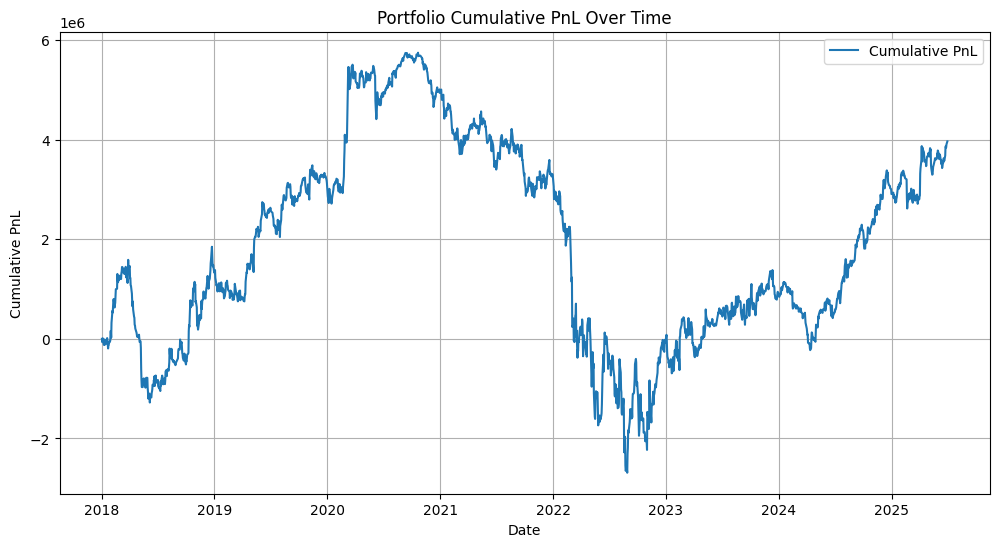

In [11]:
cum_pnl = trading_results["portfolio_cum_pnl"]

plt.figure(figsize=(12, 6))
plt.plot(cum_pnl, label="Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.title("Portfolio Cumulative PnL Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
benchmark = "SPY"
backtest = BackTest(
    trading_results=trading_results,
    start_date=start_date,
    end_date=end_date,
    baskets=filtered_baskets,
    initial_capital=initial_capital,
    benchmark=benchmark,
    risk_free_rate=0.01,
    year_convention=252
)

performance_summary = backtest.summary()
print("\n--- Performance Summary ---")
for metric, value in performance_summary.items():
    print(f"{metric}: {value}")

c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  6 of 6 completed
c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed
c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed


--- Performance Summary ---
alpha: 8.41068157035791
beta: -2.6894985962566644
sharpe_ratio: 0.2581341031841806
sortino_ratio: 0.38914943770851
drawdown: -1.8175746574834204
win_rate: 0.49256110520722635
